# Task 03 - MINIMAX
## Pattern Recognition and Machine Learning

In [21]:
%load_ext autoreload
%autoreload 2
# uncomment following for interactive matplotlib
# %matplotlib notebook
from minimax import *
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy
from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load data from *.npz files

In [25]:
data = np.load("data_33rpz_03_minimax.npz", allow_pickle=True)
Alphabet = data["Alphabet"]
images_test = data["images_test"].item()
cont = data["cont"].item()
discrete = data["discrete"].item()

In [44]:
D1 = discrete['C'] # Chuck
D2 = discrete['N'] # Norris
letters = 'CN'
q_minimax_discrete, risk_minimax_discrete = minmax_strategy_discrete(D1, D2)

images_test_set, labels_test_set = create_test_set(images_test, letters)

labels_estimated_discrete = classify_discrete(images_test_set, q_minimax_discrete)
error_discrete = classification_error_discrete(images_test_set, labels_test_set, q_minimax_discrete)

##  BONUS TASK

Go through the chapter on non-Bayesian tasks in SH10 book [2], especially the parts discussing solution of the minimax task by linear programming (pages 25, 31, 35-38, 40-41, 46-47). Solve the above classification task using linear programming as described on page 47.

### Hints:

1. Work with the discrete measurements x
2. Represent the sought strategy (classification function) as a table α, with $α(i,k)$ corresponding to the probability of classification of bin 'i' to class 'k' such that $α(i,k) >= 0$ and $sum_k α(i,k) = 1$.
3. Reformulate the task in a matrix form according to equation 2.53 in SH10, page 47
4. Solve the task numerically using scipy.optimize.linprog.
5. Compare the obtained results with the results of the classification above.



<b> 1. Work with the discrete measurements x </b>

In [27]:
C = discrete['C'] # C
N = discrete['N'] # N

In [28]:
for i in range(C['Prob'].shape[0]):
    print('bin:',i-10,' \t' , np.round_(C['Prob'][i], 3), '\t', np.round_(N['Prob'][i],3) )

bin: -10  	 0.0 	 0.0
bin: -9  	 0.0 	 0.0
bin: -8  	 0.0 	 0.0
bin: -7  	 0.014 	 0.0
bin: -6  	 0.057 	 0.0
bin: -5  	 0.329 	 0.0
bin: -4  	 0.357 	 0.0
bin: -3  	 0.129 	 0.0
bin: -2  	 0.086 	 0.0
bin: -1  	 0.029 	 0.071
bin: 0  	 0.0 	 0.443
bin: 1  	 0.0 	 0.343
bin: 2  	 0.0 	 0.1
bin: 3  	 0.0 	 0.043
bin: 4  	 0.0 	 0.0
bin: 5  	 0.0 	 0.0
bin: 6  	 0.0 	 0.0
bin: 7  	 0.0 	 0.0
bin: 8  	 0.0 	 0.0
bin: 9  	 0.0 	 0.0
bin: 10  	 0.0 	 0.0


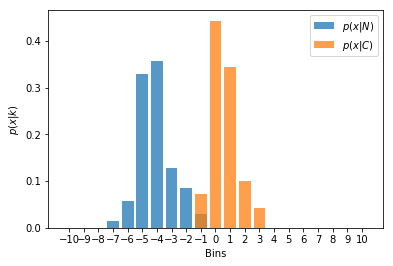

In [29]:
#plt.scatter(np.arange(-10,11,1), M['Prob'])
plt.bar(np.arange(-10,11,1), C['Prob'], width=0.8, alpha=0.75)
#plt.scatter(np.arange(-10,11,1), D['Prob'])
plt.bar(np.arange(-10,11,1), N['Prob'], width=0.8, alpha=0.75)
plt.xticks(np.arange(-10,11,1, dtype = int))
plt.xlabel('Bins')
plt.ylabel(r'$p(x|k)$')
plt.legend([r'$p(x|N)$', r'$p(x|C)$'])
plt.show()

<b>2. Represent the sought strategy (classification function) as a table α, with $α(i,k)$ corresponding to the probability of classification of bin 'i' to class 'k' such that $α(i,k) \geq 0$ and $sum_k α(i,k) = 1$. </b>

In [30]:
a = []
for i in range(C['Prob'].shape[0]):
    #if both probabilities are equal then 0.5 for each
    if C['Prob'][i] == N['Prob'][i]:
        a.append([0.5, 0.5])
    #if one is 0 then another will be 1
    elif C['Prob'][i] == 0 and N['Prob'][i] != 0:
        a.append([0., 1.])
    elif C['Prob'][i] != 0 and N['Prob'][i] == 0:
        a.append([1., 0.])
    #if both are not equal to 0 then i calculate:
    #dividing probability of one by the sum of probabilities of both classes
    elif C['Prob'][i] != 0 and N['Prob'][i] != 0:
        p_C = C['Prob'][i]/(C['Prob'][i]+N['Prob'][i])
        p_N = N['Prob'][i]/(C['Prob'][i]+N['Prob'][i])
        a.append([p_C, p_N])
a = np.array(a)

In [31]:
a

array([[0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.28571427, 0.71428573],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ]])

<b> 3. Reformulate the task in a matrix form according to equation 2.53 in SH10, page 47
 </b> <br>
 $min \space c$, <br>
 $\tau(k) | c + \sum_{x \in X} \alpha(x,k) p_{(X|K)}(x|k) \geq 1$ <br>
 $t(x) | \sum_{x \in X} \alpha(x,k) = 1$ , $x \in X$, <br>
 $\alpha(x,k) \geq 0$ , $x \in X$, $k \in K$,

$\tau(k) | c \geq 1 - \sum_{x \in X} \alpha(x,k) p_{(X|K)}(x|k)$ <br>
$1 - \sum_{x \in X} \alpha(x,k) p_{(X|K)}(x|k) = bound_k$ <br>
Bound for N:

In [32]:
b_N =1 - np.sum(N['Prob']*a[:,0])
b_N

0.9795918370387993

Bound for C:

In [33]:
b_C =1 - np.sum(C['Prob']*a[:,1])
b_C

0.9795918361340858

In [34]:
b = [-b_N, -b_C]

$min \space c$, <br>
$ c \geq bound_N$ = $ -c \leq -bound_N$ <br>
$ c \geq bound_C$ = $ -c \leq -bound_C$ 

In [35]:
c = [1]
A = [[-1], [-1]]
x0_bounds = (None, None)

In [36]:
res = opt.linprog(c, A_ub=A, b_ub=b, bounds=[x0_bounds])

In [37]:
c = res['x'][0]
res

     con: array([], dtype=float64)
     fun: 0.9795918370387993
 message: 'The solution was determined in presolve as there are no non-trivial constraints.'
     nit: 0
   slack: array([0.00000000e+00, 9.04713415e-10])
  status: 0
 success: True
       x: array([0.97959184])

$k^* = argmax_{k \in K} (\tau(k) p_{X|K}(x|k))$ <br>
<br>
$\tau(k) = c + \sum_{x \in X} \alpha(x,k) p_{(X|K)}(x|k) - 1$ <br>
$\tau(N) = c + bound_N - 1$ <br>
$\tau(C) = c + bound_C - 1$ <br>
<br>
In case with only two classes we compare $\tau(N) p_{X|K}(x|N)$ and $\tau(C) p_{X|K}(x|C)$ and chose such $k \in \{N, C\}$ to have max value

In [41]:
k = np.zeros((21,), dtype=np.int32)
for i in range(21):
    if (c + b_C - 1)*C['Prob'][i] < (c + b_N - 1)*N['Prob'][i]:
        k[i] = 1
print('k: {}'.format(k))
print('q: {}'.format(q_minimax_discrete))

k: [0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0]
q: [0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0]


In [42]:
labels_estimated_discrete = classify_discrete(images_test_set, k)
error_bonus= classification_error_discrete(images_test_set, labels_test_set, k)

Error bonus: 0.0667
Error discrete: 0.0667


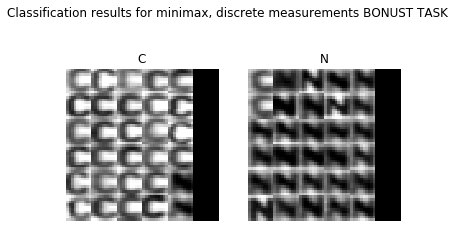

In [45]:
fig = plt.figure()
show_classification(images_test_set, labels_estimated_discrete, letters)
plt.suptitle('Classification results for minimax, discrete measurements BONUST TASK')
# plt.savefig('minmax_classif_discrete_' + letters.lower() + '.png')
plt.savefig('minmax_classif_discrete_bonus.png')
print('Error bonus: {:.4f}'.format(error_bonus))
print('Error discrete: {:.4f}'.format(error_discrete))